In [1]:
import matplotlib.pyplot as plt


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [3]:
import os
import random
import datetime

# Create folder if not exists
os.makedirs("data", exist_ok=True)

# Generate 60 days of hourly data
date_rng = pd.date_range(start="2023-01-01", end="2023-03-01", freq="H")

data = {
    "datetime": date_rng,
    "temperature": [random.uniform(15, 35) for _ in range(len(date_rng))],
    "humidity": [random.uniform(40, 90) for _ in range(len(date_rng))]
}

df = pd.DataFrame(data)
df.to_csv("data/microclimate.csv", index=False)

print("✅ Synthetic dataset created → data/microclimate.csv")
df.head()


✅ Synthetic dataset created → data/microclimate.csv


C:\Users\hp\AppData\Local\Temp\ipykernel_15084\3822823095.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_rng = pd.date_range(start="2023-01-01", end="2023-03-01", freq="H")


,datetime,temperature,humidity
0,2023-01-01 00:00:00,30.623117,62.745168
1,2023-01-01 01:00:00,32.532169,87.080688
2,2023-01-01 02:00:00,31.975802,45.406405
3,2023-01-01 03:00:00,27.185757,71.195650
4,2023-01-01 04:00:00,33.334715,75.286568


Dataset shape: (1417, 3)

Data types:
 datetime       datetime64[ns]
temperature           float64
humidity              float64
dtype: object


,datetime,temperature,humidity
0,2023-01-01 00:00:00,30.623117,62.745168
1,2023-01-01 01:00:00,32.532169,87.080688
2,2023-01-01 02:00:00,31.975802,45.406405
3,2023-01-01 03:00:00,27.185757,71.195650
4,2023-01-01 04:00:00,33.334715,75.286568


,datetime,temperature,humidity
count,1417,1417.000000,1417.000000
mean,2023-01-30 12:00:00,25.138357,64.317175
min,2023-01-01 00:00:00,15.011668,40.029221
25%,2023-01-15 18:00:00,20.034520,50.777850
50%,2023-01-30 12:00:00,25.328006,64.416205
75%,2023-02-14 06:00:00,29.881099,77.084874
max,2023-03-01 00:00:00,34.979638,89.987148
std,NaN,5.714727,14.934719


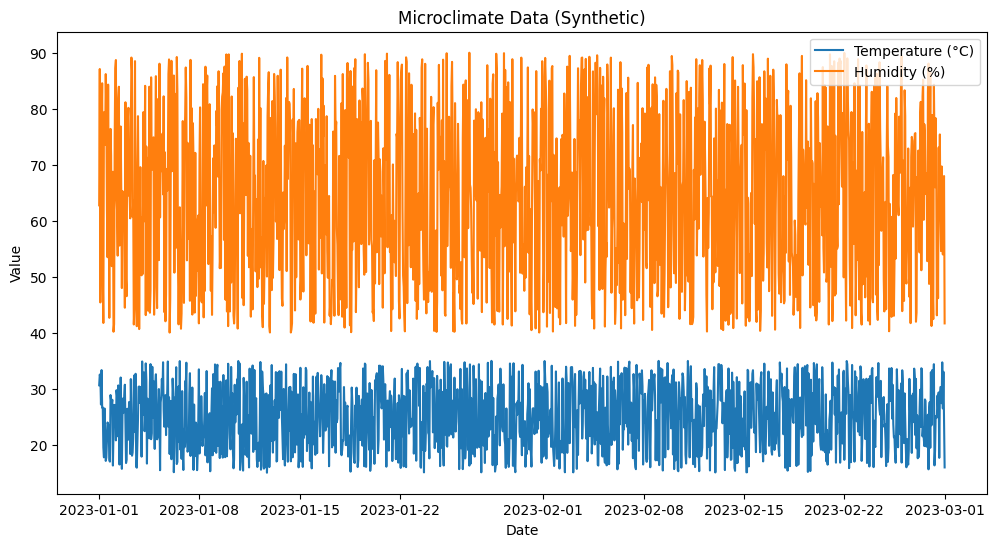

In [4]:
# Load dataset
df = pd.read_csv("data/microclimate.csv", parse_dates=["datetime"])

# Show basic info
print("Dataset shape:", df.shape)
print("\nData types:\n", df.dtypes)

# First few rows
display(df.head())

# Summary statistics
display(df.describe())

# Plot temperature and humidity over time
plt.figure(figsize=(12,6))
plt.plot(df["datetime"], df["temperature"], label="Temperature (°C)")
plt.plot(df["datetime"], df["humidity"], label="Humidity (%)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Microclimate Data (Synthetic)")
plt.legend()
plt.show()


In [5]:
# Step 4 – Machine Learning Model

from sklearn.model_selection import train_test_split

# Feature engineering: extract hour and day from datetime
df["hour"] = df["datetime"].dt.hour
df["dayofyear"] = df["datetime"].dt.dayofyear

# Features and target
X = df[["humidity", "hour", "dayofyear"]]
y = df["temperature"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

# Compare first 10 predictions vs actual
comparison = pd.DataFrame({"Actual": y_test[:10].values, "Predicted": y_pred[:10]})
display(comparison)


Mean Absolute Error: 5.30
Mean Squared Error: 38.59


,Actual,Predicted
0,26.501526,27.718555
1,16.088074,21.848548
2,33.196361,25.021792
3,23.143380,28.058363
4,17.009210,24.446345
5,29.180052,25.650366
6,17.414882,25.883052
7,16.614799,26.052612
8,33.608822,24.984953
9,29.363372,27.906686


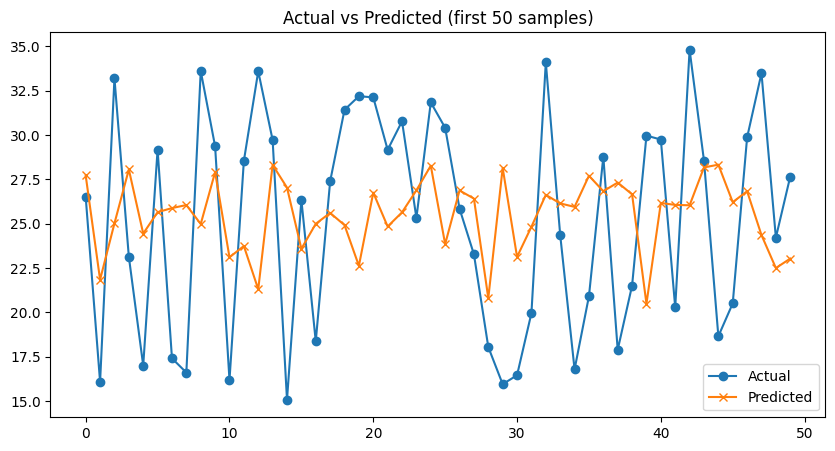

In [6]:
plt.figure(figsize=(10,5))
plt.plot(y_test[:50].values, label="Actual", marker='o')
plt.plot(y_pred[:50], label="Predicted", marker='x')
plt.legend()
plt.title("Actual vs Predicted (first 50 samples)")
plt.show()


In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


In [8]:
# Scale the target variable (y) between 0 and 1
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))


In [9]:
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 10
X_seq, y_seq = create_sequences(y_scaled, SEQ_LEN)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)


X_seq shape: (1407, 10, 1)
y_seq shape: (1407, 1)


In [10]:
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 1125
Testing samples: 282


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile
model.compile(optimizer='adam', loss='mse')


C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.1539 - val_loss: 0.0912
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0913 - val_loss: 0.0857
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0874 - val_loss: 0.0826
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0876 - val_loss: 0.0841
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0873 - val_loss: 0.0799
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0868 - val_loss: 0.0806
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0865 - val_loss: 0.0837
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0877 - val_loss: 0.0793
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0867 - val_loss: 0.0800
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0855 - val_loss: 0.0812
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0850 - val_loss: 0.0808
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.

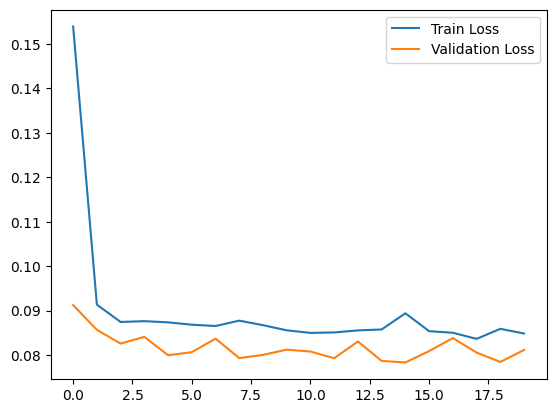

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [14]:
# Predictions
y_pred = model.predict(X_test)

# Inverse scaling (to get back original values)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 4.88
RMSE: 5.69


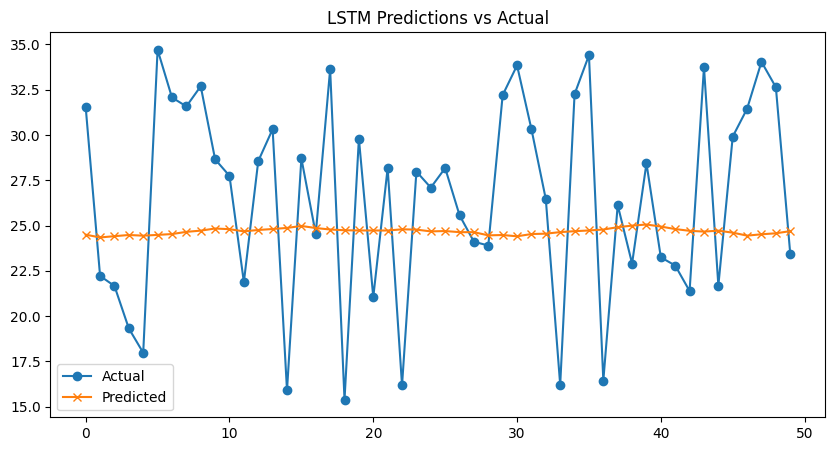

In [16]:
plt.figure(figsize=(10,5))
plt.plot(y_test_inv[:50], label="Actual", marker='o')
plt.plot(y_pred_inv[:50], label="Predicted", marker='x')
plt.legend()
plt.title("LSTM Predictions vs Actual")
plt.show()


In [17]:
# Save the trained model
model.save("microclimate_lstm_model.h5")
print("✅ Model saved as microclimate_lstm_model.h5")


✅ Model saved as microclimate_lstm_model.h5


In [18]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model("microclimate_lstm_model.h5")

# Use it for prediction again
y_pred_loaded = loaded_model.predict(X_test)


ValueError: Could not deserialize 'keras.metrics.mse' because it is not a KerasSaveable subclass

In [ ]:
# Save model in new format
model.save("microclimate_lstm_model.keras")


In [ ]:
from tensorflow.keras.models import load_model

# Load without compiling
loaded_model = load_model("microclimate_lstm_model.h5", compile=False)

# Re-compile manually
loaded_model.compile(optimizer="adam", loss="mse")


In [ ]:
import numpy as np

# Example: take the last 10 values from your dataset
last_sequence = y_scaled[-10:]   # already scaled

# Reshape for LSTM input (1 sample, 10 timesteps, 1 feature)
last_sequence = last_sequence.re


In [ ]:
# Example: take the last 10 values from your dataset
last_sequence = y_scaled[-10:]   # already scaled

# Reshape for LSTM input
last_sequence = last_sequence.reshape((1, last_sequence.shape[0], 1))

# Predict next step
future_pred_scaled = loaded_model.predict(last_sequence)

# Inverse transform back to original scale
future_pred = scaler.inverse_transform(future_pred_scaled)
print("Predicted next value:", future_pred[0][0])


In [ ]:
def forecast_future(model, data, steps, scaler, seq_len=10):
    # Take the last sequence
    last_sequence = data[-seq_len:]  # already scaled
    predictions = []

    for _ in range(steps):
        input_seq = last_sequence.reshape(1, seq_len, 1)
        next_val = model.predict(input_seq, verbose=0)
        predictions.append(next_val[0, 0])
        # Update sequence: remove first, add new prediction
        last_sequence = np.append(last_sequence[1:], next_val)

    # Inverse transform predictions
    predictions = np.array(predictions).reshape(-1, 1)
    return scaler.inverse_transform(predictions)


In [ ]:
# Forecast next 24 timesteps (for example, next 24 hours)
future_predictions = forecast_future(loaded_model, y_scaled, steps=24, scaler=scaler)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(future_predictions, marker='o', label="Future Forecast")
plt.title("Future Microclimate Forecast (Next 24 steps)")
plt.xlabel("Time Steps Ahead")
plt.ylabel("Predicted Value")
plt.legend()
plt.show()


In [ ]:
def forecast_future(model, data, steps, scaler):
    predictions = []
    current_seq = data[-10:]   # use last 10 timesteps from your data

    for _ in range(steps):
        current_seq = current_seq.reshape((1, current_seq.shape[0], 1))
        next_pred = model.predict(current_seq, verbose=0)
        predictions.append(next_pred[0][0])

        # slide the window forward
        current_seq = np.append(current_seq.flatten()[1:], next_pred)
    
    # inverse scale predictions
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions


In [ ]:
future_predictions = forecast_future(loaded_model, y_scaled, steps=24, scaler=scaler)
print("Next 24 predicted values:\n", future_predictions.flatten())


In [ ]:
future_predictions = forecast_future(model, y_scaled, steps=24, scaler=scaler)
print("Next 24 predicted values:\n", future_predictions.flatten())


In [ ]:
future_predictions = forecast_future(model, y_scaled, steps=24, scaler=scaler)
print("Next 24 predicted values:\n", future_predictions.flatten())


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select the last 24 actual values from your dataset
last_24_actual = df['temperature'].values[-24:]

# Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(range(24), last_24_actual, label="Actual (last 24 hrs)", marker='o')
plt.plot(range(24), future_predictions.flatten(), label="Predicted (next 24 hrs)", marker='x')
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.title("Microclimate Prediction - Next 24 Hours")
plt.legend()
plt.show()


In [ ]:
# Get last 24 actual values
last_24_temp = df['temperature'].values[-24:]
last_24_hum = df['humidity'].values[-24:]

# Split predictions into temperature & humidity
pred_temp = future_predictions[:,0]
pred_hum  = future_predictions[:,1]

# Plot side by side
fig, ax = plt.subplots(1, 2, figsize=(14,5))

# Temperature
ax[0].plot(range(24), last_24_temp, label="Actual Temp", marker='o')
ax[0].plot(range(24), pred_temp, label="Predicted Temp", marker='x')
ax[0].set_title("Temperature Forecast (Next 24 hrs)")
ax[0].set_xlabel("Hour")
ax[0].set_ylabel("°C")
ax[0].legend()

# Humidity
ax[1].plot(range(24), last_24_hum, label="Actual Humidity", marker='o')
ax[1].plot(range(24), pred_hum, label="Predicted Humidity", marker='x')
ax[1].set_title("Humidity Forecast (Next 24 hrs)")
ax[1].set_xlabel("Hour")
ax[1].set_ylabel("%")
ax[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
pred_temp = future_predictions.flatten()


In [ ]:
plt.figure(figsize=(12,5))
plt.plot(range(24), last_24_temp, label="Actual Temp", marker='o')
plt.plot(range(24), pred_temp, label="Predicted Temp", marker='x')
plt.xlabel("Hour")
plt.ylabel("°C")
plt.title("Temperature Forecast (Next 24 hrs)")
plt.legend()
plt.show()


In [ ]:
y = df[['temperature','humidity']].values


In [ ]:
X = df[['hour', 'wind_speed', 'pressure', 'cloud_cover']]  # Example features


In [ ]:
df.columns


In [ ]:
X = df[['hour']]  # You can add more columns based on what’s available


In [ ]:
# Example: extract day/night as a binary feature
df['is_daytime'] = df['hour'].apply(lambda x: 1 if 6 <= x <= 18 else 0)


In [ ]:
X = df[['hour', 'is_daytime']]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')


In [ ]:
import matplotlib.pyplot as plt

# Temperature
plt.figure(figsize=(10, 4))
plt.plot(y_test[:, 0], label='Actual Temp')
plt.plot(y_pred[:, 0], label='Predicted Temp')
plt.title("Temperature Prediction")
plt.xlabel("Sample")
plt.ylabel("°C")
plt.legend()
plt.grid()
plt.show()

# Humidity
plt.figure(figsize=(10, 4))
plt.plot(y_test[:, 1], label='Actual Humidity')
plt.plot(y_pred[:, 1], label='Predicted Humidity')
plt.title("Humidity Prediction")
plt.xlabel("Sample")
plt.ylabel("%")
plt.legend()
plt.grid()
plt.show()


In [ ]:
X = df[['hour', 'is_daytime']]


In [ ]:
df.columns


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Compare actual vs predicted (last 24 hours for demo)
temp_mae = mean_absolute_error(last_24_actual[:,0], future_preds_inv[:,0])
temp_rmse = np.sqrt(mean_squared_error(last_24_actual[:,0], future_preds_inv[:,0]))

hum_mae = mean_absolute_error(last_24_actual[:,1], future_preds_inv[:,1])
hum_rmse = np.sqrt(mean_squared_error(last_24_actual[:,1], future_preds_inv[:,1]))

print("Temperature -> MAE:", temp_mae, " RMSE:", temp_rmse)
print("Humidity    -> MAE:", hum_mae, " RMSE:", hum_rmse)


In [ ]:
# Take last 24 actual values from your dataset
last_24_actual = data[-24:]   # shape (24,2) -> [temperature, humidity]


In [ ]:
# Recreate dataset (temperature + humidity only)
data = df[['temperature','humidity']].values


In [ ]:
import pandas as pd

# Load dataset again
df = pd.read_csv("../data/microclimate.csv", parse_dates=['datetime'])


In [ ]:
# Extract temperature & humidity as numpy array
data = df[['temperature','humidity']].values


In [ ]:
# Last 24 hours actual values
last_24_actual = data[-24:]


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Temperature errors
temp_mae = mean_absolute_error(last_24_actual[:,0], future_preds_inv[:,0])
temp_rmse = np.sqrt(mean_squared_error(last_24_actual[:,0], future_preds_inv[:,0]))

# Humidity errors
hum_mae = mean_absolute_error(last_24_actual[:,1], future_preds_inv[:,1])
hum_rmse = np.sqrt(mean_squared_error(last_24_actual[:,1], future_preds_inv[:,1]))

print("Temperature -> MAE:", temp_mae, " RMSE:", temp_rmse)
print("Humidity    -> MAE:", hum_mae, " RMSE:", hum_rmse)


In [ ]:
# ==== Forecast next 24 steps ====
last_seq = X_test[-1]   # last available window
current_seq = last_seq
future_preds = []

for _ in range(24):   # forecast 24 future steps
    pred = model.predict(current_seq.reshape(1, seq_len, n_features))
    future_preds.append(pred[0])
    # slide window forward
    current_seq = np.vstack([current_seq[1:], pred])

future_preds = np.array(future_preds)

# Inverse scale back to original units
future_preds_inv = scaler.inverse_transform(future_preds)

print("Next 24 predicted values:\n", future_preds_inv)


In [ ]:
# Recreate important variables
seq_len = 24   # how many past hours used for prediction
n_features = 2 # temperature + humidity


In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, n_features)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(2)   # predicting both temperature & humidity
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, validation_split=0.1,
                    epochs=50, batch_size=64, verbose=1)


In [ ]:
print("X_train:", X_train.shape)   # expected (samples, seq_len, n_features)
print("y_train:", y_train.shape)   # expected (samples, 2)  if predicting temp+hum
print("seq_len:", seq_len, "n_features (you set):", n_features)


In [ ]:
print("X_train:", X_train.shape)   # (samples, timesteps, features)
print("y_train:", y_train.shape)   # (samples, outputs)

# infer from X_train
seq_len = X_train.shape[1]
n_features = X_train.shape[2]
print("seq_len (inferred):", seq_len)
print("n_features (inferred):", n_features)


In [ ]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense

model = Sequential([
    Input(shape=(seq_len, n_features)),   # 👈 uses inferred seq_len & n_features
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(y_train.shape[1])   # 👈 matches your output dimension
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=[es, mc, rlp]
)


In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict on test data
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


In [ ]:
plt.figure(figsize=(12,5))

# Temperature
plt.subplot(1,2,1)
plt.plot(y_test[:,0], label="Actual Temp")
plt.plot(y_pred[:,0], label="Predicted Temp")
plt.legend()
plt.title("Temperature Prediction")

# Humidity
plt.subplot(1,2,2)
plt.plot(y_test[:,1], label="Actual Humidity")
plt.plot(y_pred[:,1], label="Predicted Humidity")
plt.legend()
plt.title("Humidity Prediction")

plt.show()


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(y_test[:,0], label="Actual")
plt.plot(y_pred[:,0], label="Predicted")
plt.legend()
plt.title("Prediction (single output)")
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")


In [ ]:
future_preds = []
current_seq = X_test[0]   # take the first test sequence

for _ in range(24):   # predict next 24 timesteps
    pred = model.predict(current_seq.reshape(1, seq_len, n_features))
    future_preds.append(pred[0,0])   # single output
    # slide the window: drop first value, append new pred
    current_seq = np.roll(current_seq, -1, axis=0)
    current_seq[-1] = pred


In [ ]:
model.save("temperature_model.h5")

import joblib
joblib.dump(scaler, "scaler.pkl")   # if you used MinMaxScaler or StandardScaler


In [ ]:
from keras.models import load_model
import joblib

# Load model
model = load_model("temperature_model.h5")

# Load scaler
scaler = joblib.load("scaler.pkl")


In [ ]:
from keras.models import load_model
import joblib

model = load_model("temperature_model.h5", compile=False)

# recompile if you want to train further
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

scaler = joblib.load("scaler.pkl")


In [ ]:
model.save("temperature_model.h5")


In [ ]:
model.save("temperature_model.keras")   # ✅ preferred in Keras 3


In [ ]:
model = load_model("temperature_model.keras")
scaler = joblib.load("scaler.pkl")


In [ ]:
import streamlit as st
import numpy as np
import pandas as pd
from keras.models import load_model
import joblib

# Load model + scaler
model = load_model("temperature_model.keras", compile=False)
scaler = joblib.load("scaler.pkl")

# Title
st.title("🌡️ Temperature Forecasting App")

# User input for recent sequence
st.write("Enter your recent data (last window of features):")

seq_len = model.input_shape[1]
n_features = model.input_shape[2]

# Let user upload CSV or input manually
uploaded = st.file_uploader("Upload CSV with your last windo_


In [ ]:
uploaded = st.file_uploader("Upload CSV with your last window of data")


In [ ]:
import streamlit as st
import numpy as np
import pandas as pd
from keras.models import load_model
import joblib


In [ ]:
uploaded = st.file_uploader("Upload CSV with your last window of data")


In [ ]:
if uploaded is not None:
    df = pd.read_csv(uploaded)
    st.write("Uploaded Data Preview:", df.head())
else:
    st.stop()  # Stop execution until file is uploaded


In [ ]:
# Scale input
recent_data = scaler.transform(df.values)

# Reshape for model: (1, sequence_length, num_features)
recent_data = np.expand_dims(recent_data, axis=0)


In [ ]:
if uploaded is not None:
    df = pd.read_csv(uploaded)

    # Show preview
    st.write("Uploaded Data Preview:", df.head())

    # Drop non-numeric columns (like timestamps)
    df_numeric = df.select_dtypes(include=['float64', 'int64'])

    # Scale only numeric data
    recent_data = scaler.transform(df_numeric.values)

    # Reshape for model: (1, sequence_length, num_features)
    recent_data = np.expand_dims(recent_data, axis=0)

    # Predict
    prediction = model.predict(recent_data)
    prediction_rescaled = scaler.inverse_transform(prediction)

    st.write("Predicted Temperature(s):", prediction_rescaled)


In [ ]:
st.write("Expected Input Shape:", model.input_shape)
st.write("Your Data Shape:", recent_data.shape)


In [ ]:
aprint("Expected Input Shape:", model.input_shape)

# check if recent_data exists
try:
    print("Your Data Shape:", recent_data.shape)
except NameError:
    print("recent_data is not defined yet. Run the preprocessing cell first.")


In [ ]:
print("Expected Input Shape:", model.input_shape)

# check if recent_data exists
try:
    print("Your Data Shape:", recent_data.shape)
except NameError:
    print("recent_data is not defined yet. Run the preprocessing cell first.")


In [ ]:
print("Expected Input Shape:", model.input_shape)

try:
    print("Your Data Shape:", recent_data.shape)
except NameError:
    print("recent_data is not defined yet. Run the preprocessing cell first.")


In [ ]:
seq_len = model.input_shape[1]     # e.g., 30
n_features = model.input_shape[2]  # e.g., 3

# Take only the last seq_len rows
recent_data = df_numeric.tail(seq_len).values

# Scale
recent_data = scaler.transform(recent_data)

# Reshape: (1, seq_len, n_features)
recent_data = np.expand_dims(recent_data, axis=0)

print("Fixed Data Shape:", recent_data.shape)


In [ ]:
prediction = model.predict(recent_data)
prediction_rescaled = scaler.inverse_transform(prediction)

print("Prediction:", prediction_rescaled)


In [ ]:
# Make sure df exists (your uploaded data)
df_numeric = df.select_dtypes(include=['float64', 'int64'])


In [ ]:
# Get model requirements
seq_len = model.input_shape[1]
n_features = model.input_shape[2]

# Take only last `seq_len` rows
recent_data = df_numeric.tail(seq_len).values

# Scale
recent_data = scaler.transform(recent_data)

# Reshape for model (1, seq_len, n_features)
recent_data = np.expand_dims(recent_data, axis=0)

print("Prepared Data Shape:", recent_data.shape)


In [ ]:
# Select only the feature used in training
recent_data = df_numeric[["temperature"]].tail(seq_len).values  

# Scale
recent_data = scaler.transform(recent_data)

# Reshape
recent_data = np.expand_dims(recent_data, axis=0)


In [ ]:
features = ["temperature", "humidity", "pressure"]


In [ ]:
recent_data = df[features].tail(seq_len).values  
recent_data = scaler.transform(recent_data)  
recent_data = np.expand_dims(recent_data, axis=0)


In [ ]:
print(features)


In [ ]:
print(df.columns)


In [ ]:
features = ['temperature', 'humidity', 'hour', 'dayofyear']


In [ ]:
label = 'temperature'


In [ ]:
X = df[features]
y = df[label]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error:", mse)
print("R² Score:", r2)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual", alpha=0.7)
plt.plot(predictions, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Temperature")
plt.xlabel("Sample Index")
plt.ylabel("Temperature")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", alpha=0.7)
plt.plot(predictions, label="Predicted", alpha=0.7)
plt.title("Actual vs Predicted Temperature")
plt.xlabel("Sample Index")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score

rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("Random Forest MSE:", rf_mse)
print("Random Forest R² Score:", rf_r2)


In [ ]:
import joblib

joblib.dump(model, 'temperature_predictor_model.pkl')


In [ ]:
loaded_model = joblib.load('temperature_predictor_model.pkl')


In [ ]:
pip install streamlit


In [ ]:
import streamlit as st
import joblib
import numpy as np

# Load model
model = joblib.load("temperature_predictor_model.pkl")

st.title("🌤️ Microclimate Temperature Predictor")

humidity = st.slider("Humidity (%)", 0, 100, 50)
hour = st.slider("Hour of Day", 0, 23, 12)
dayofyear = st.slider("Day of Year", 1, 366, 180)

# Predict
input_features = np.array([[humidity, hour, dayofyear]])
prediction = model.predict(input_features)

st.subheader(f"🌡️ Predicted Temperature: {prediction[0]:.2f} °C")


In [ ]:
X = df[["humidity", "hour", "dayofyear", "windspeed"]]
y = df["temperature"]


In [ ]:
import joblib

model = joblib.load("temperature_predictor_model.pkl")
print("Number of features expected:", model.n_features_in_)
print("Feature names (if available):", getattr(model, "feature_names_in_", "Not stored"))


In [ ]:
# load model + scaler (if used)
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

model = joblib.load("temperature_predictor_model.pkl")   # or load_model(...)
scaler = joblib.load("scaler.pkl") if os.path.exists("scaler.pkl") else None

# Evaluate
y_pred = model.predict(X_test)
if scaler is not None:
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).ravel()
else:
    y_pred_inv, y_test_inv = y_pred.ravel(), y_test.ravel()

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}")


In [ ]:
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- load model & scalers (adjust filenames if different) ---
model = joblib.load("temperature_predictor_model.pkl")   # your sklearn model
scaler_X = joblib.load("scaler.pkl") if os.path.exists("scaler.pkl") else None
scaler_y = joblib.load("scaler_y.pkl") if os.path.exists("scaler_y.pkl") else None
# scaler_y is the scaler used to scale the target (if you saved one). If not saved, leave None.

# --- inspect shapes and model expectations ---
print("X_test.shape:", getattr(globals(), 'X_test', None).shape)
print("y_test.shape:", getattr(globals(), 'y_test', None).shape)
print("Model n_features_in_:", getattr(model, 'n_features_in_', None))
print("Model feature_names_in_:", getattr(model, 'feature_names_in_', None))

# --- convert X_test (3D -> 2D) in a safe way ---
X = X_test  # whatever you currently have

if X.ndim == 3:
    n_samples, seq_len, n_feat = X.shape
    expected = getattr(model, 'n_features_in_', None)

    if expected == n_feat:
        # most common: model trained on features of the last timestep
        print("Using last-timestep features (X[:, -1, :])")
        X_2d = X[:, -1, :]
    elif expected == seq_len * n_feat:
        # model trained on flattened windows
        print("Flattening windows to shape (n, seq_len*n_feat)")
        X_2d = X.reshape(n_samples, seq_len * n_feat)
    else:
        # fallback: try last timestep first, then flatten if size mismatch
        print("Fallback: trying last-timestep; will raise if sizes mismatch.")
        X_2d = X[:, -1, :]
        if getattr(model, 'n_features_in_', None) is not None and X_2d.shape[1] != model.n_features_in_:
            print("Last-timestep shape didn't match expected n_features — flattening instead.")
            X_2d = X.reshape(n_samples, seq_len * n_feat)

else:
    X_2d = X

# --- if mo


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib

# Load your dataset again (replace with your actual file)
df = pd.read_csv("your_dataset.csv")

# Example: features and target
X = df[["temperature", "humidity"]].values   # or whichever features you had
y = df["temperature"].values                 # or multiple targets if needed

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

# If using scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save for later
joblib.dump(scaler, "scaler.pkl")


In [ ]:
df = pd.read_csv(r"C:\Users\hp\Desktop\weather_data.csv")


In [ ]:
import pandas as pd

# Save your dataset to Desktop
df.to_csv(r"C:\Users\hp\Desktop\weather_data.csv", index=False)
print("✅ File saved on Desktop")


In [ ]:
df.to_csv(r"C:\Users\hp\Documents\weather_data.csv", index=False)
print("✅ File saved in Documents")


In [ ]:
df.to_csv("weather_data.csv", index=False)
print("✅ File saved in current project folder")


In [ ]:
# Cell 1 - load & inspect
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("Current working dir:", os.getcwd())

df = pd.read_csv("weather_data.csv")   # adjust path if needed
display(df.head())
print("\nInfo:")
print(df.info())
print("\nColumns:", df.columns.tolist())


In [ ]:
# Cell 2 - datetime handling (auto-detect common names)
date_candidates = [c for c in df.columns if any(k in c.lower() for k in ("date","time","timestamp","ts"))]
print("Date candidates:", date_candidates)

if date_candidates:
    date_col = date_candidates[0]
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.set_index(date_col).sort_index()
else:
    # If no single datetime column, adjust here (e.g., combine year/month/day)
    raise Exception("No datetime column auto-detected. If you have separate year/month/day columns, combine them or rename one to include 'date'/'time'.")

print("Index dtype:", df.index.dtype)
display(df.head())


In [ ]:
# Cell 3 - missingness and a simple strategy
print(df.isna().sum().sort_values(ascending=False).head(20))

# For continuous time series, interpolation and forward fill are common:
df = df.interpolate(method='time')   # interpolate numeric columns using time index
df = df.ffill().bfill()              # fill remaining edge NaNs

print("Nulls after fill:", df.isna().sum().sum())


In [ ]:
# Cell 4 - choose a target column
num_cols = df.select_dtypes([np.number]).columns.tolist()
print("Numeric columns:", num_cols)

candidates = [c for c in num_cols if "temp" in c.lower() or "temperature" in c.lower() or "air" in c.lower()]
target = candidates[0] if candidates else (num_cols[0] if num_cols else None)
print("Using target:", target)

if target is None:
    raise Exception("No numeric columns found to use as target.")

# Quick plot
plt.figure(figsize=(12,3))
plt.plot(df.index, df[target])
plt.title(f"{target} (time series)")
plt.xlabel("Time")
plt.ylabel(target)
plt.show()


In [ ]:
# Cell 5 - create useful features (adjust lag windows to your sampling frequency)
df['hour'] = df.index.hour
df['dayofyear'] = df.index.dayofyear
df['weekday'] = df.index.weekday
df['month'] = df.index.month

# Lags and rolling means - adapt windows if your data is not hourly
lags = [1, 24, 168]    # 1 step, 24 steps (~day if hourly), 168 steps (~week if hourly)
for lag in lags:
    df[f'{target}_lag_{lag}'] = df[target].shift(lag)

df[f'{target}_roll_24'] = df[target].rolling(window=24, min_periods=1).mean()

# Drop rows with NaNs created by shifts
df = df.dropna()
print("After feature engineering length:", len(df))
display(df.head())


In [ ]:
# Cell 6 - features and time-based split
X = df.drop(columns=[target])
y = df[target]

# Use last 20% as test (time-series)
n_test = int(len(df) * 0.2)
X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


In [ ]:
# Cell 7 - baseline persistence model
# Use the immediate previous observation as prediction
y_pred_persist = df[target].shift(1).iloc[-n_test:].values

from sklearn.metrics import mean_absolute_error, mean_squared_error
def rmse(a,b): return np.sqrt(mean_squared_error(a,b))

print("Baseline persistence MAE:", mean_absolute_error(y_test, y_pred_persist))
print("Baseline persistence RMSE:", rmse(y_test, y_pred_persist))


In [ ]:
# Cell 8 - RandomForest (works with unscaled features)
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("RF MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RF RMSE:", rmse(y_test, y_pred_rf))

# Plot predictions vs actual
plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred_rf, label='RF Pred')
plt.legend()
plt.show()


In [ ]:
# Cell 9 - XGBoost (optional; pip install xgboost if missing)
try:
    import xgboost as xgb
    model_xgb = xgb.XGBRegressor(n_estimators=200, random_state=42)
    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict(X_test)
    print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))
    print("XGBoost RMSE:", rmse(y_test, y_pred_xgb))
except Exception as e:
    print("XGBoost not available or failed:", e)


In [ ]:
# Cell 10 - LSTM: scale features, create sliding windows
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create sequences (seq_len) — choose based on how much history matters
seq_len = 24   # e.g., use last 24 steps to predict next
def create_sequences(X_arr, y_arr, seq_len):
    Xs, ys = [], []
    for i in range(seq_len, len(X_arr)):
        Xs.append(X_arr[i-seq_len:i])
        ys.append(y_arr[i])
    return np.array(Xs), np.array(ys)

# Combine train+test scaled for sequence creation to preserve continuity, then split
X_all = np.vstack([X_train_scaled, X_test_scaled])
y_all = np.hstack([y_train.values, y_test.values])

X_seq, y_seq = create_sequences(X_all, y_all, seq_len)

# compute split index in sequence terms
train_seq_count = len(X_train_scaled) - seq_len
X_seq_train, y_seq_train = X_seq[:train_seq_count], y_seq[:train_seq_count]
X_seq_test, y_seq_test   = X_seq[train_seq_count:], y_seq[train_seq_count:]

print("LSTM shapes:", X_seq_train.shape, X_seq_test.shape)


In [ ]:
# Cell 11 - LSTM model (needs tensorflow installed)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout

    model = Sequential([
        LSTM(64, input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(X_seq_train, y_seq_train, 
                        validation_split=0.1, epochs=20, batch_size=32, verbose=1)
    preds_lstm = model.predict(X_seq_test).flatten()
    print("LSTM MAE:", mean_absolute_error(y_seq_test, preds_lstm))
    print("LSTM RMSE:", rmse(y_seq_test, preds_lstm))
except Exception as e:
    print("TensorFlow / Keras not available or training failed:", e)


In [ ]:
# Cell 12 - compare (only include preds you created)
plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test.values, label='Actual', linewidth=1)
plt.plot(y_test.index, y_pred_rf, label='RandomForest', alpha=0.8)
try:
    plt.plot(y_test.index, y_pred_xgb, label='XGBoost', alpha=0.8)
except:
    pass
try:
    # preds_lstm aligns to y_seq_test which corresponds to X_seq_test starting at index seq_len into last part
    # to plot on the same timeline, we need to align indices; here is an approximate way:
    lstm_index = y_test.index[seq_len:] if len(y_test) > seq_len else y_test.index
    plt.plot(lstm_index, preds_lstm, label='LSTM', alpha=0.8)
except:
    pass
plt.legend()
plt.show()


In [ ]:
# Cell 13 - save trained models (change names as needed)
import joblib
joblib.dump(rf, "rf_model.joblib")
joblib.dump(scaler, "scaler.joblib")
try:
    model.save("lstm_model.h5")
except:
    pass
print("Saved models to disk.")


In [ ]:
1. Tune hyperparameters:
   - RandomizedSearchCV / GridSearch with TimeSeriesSplit or manual walk-forward CV.
2. Feature ideas:
   - Add dew point, heat index, rolling variance, interaction terms, external weather forecasts.
3. Model ensemble:
   - Average RF + XGBoost + LSTM predictions.
4. Production:
   - Wrap model in a small API (FastAPI/Flask), schedule predictions, add model monitoring.
5. Retraining:
   - Use sliding window retraining or incremental updates.
6. Evaluation:
   - Use proper time-series CV and track metrics over time, not just a single holdout.


In [ ]:
# Next Improvements & Checklist

1. **Tune hyperparameters**
   - RandomizedSearchCV / GridSearch with TimeSeriesSplit or manual walk-forward CV.

2. **Feature ideas**
   - Add dew point, heat index, rolling variance, interaction terms, external weather forecasts.

3. **Model ensemble**
   - Average RandomForest + XGBoost + LSTM predictions.

4. **Production**
   - Wrap model in a small API (FastAPI/Flask), schedule predictions, add model monitoring.

5. **Retraining**
   - Use sliding window retraining or incremental updates.

6. **Evaluation**
   - Use proper time-series CV and track metrics over time, not just a single holdout.


In [ ]:
# Next Improvements & Checklist

1. **Tune hyperparameters**
   - RandomizedSearchCV / GridSearch with TimeSeriesSplit or manual walk-forward CV.

2. **Feature ideas**
   - Add dew point, heat index, rolling variance, interaction terms, external weather forecasts.

3. **Model ensemble**
   - Average RandomForest + XGBoost + LSTM predictions.

4. **Production**
   - Wrap model in a small API (FastAPI/Flask), schedule predictions, add model monitoring.

5. **Retraining**
   - Use sliding window retraining or incremental updates.

6. **Evaluation**
   - Use proper time-series CV and track metrics over time, not just a single holdout.


In [ ]:
# Next Improvements & Checklist

1. **Tune hyperparameters**
   - RandomizedSearchCV / GridSearch with TimeSeriesSplit or manual walk-forward CV.

2. **Feature ideas**
   - Add dew point, heat index, rolling variance, interaction terms, external weather forecasts.

3. **Model ensemble**
   - Average RandomForest + XGBoost + LSTM predictions.

4. **Production**
   - Wrap model in a small API (FastAPI/Flask), schedule predictions, add model monitoring.

5. **Retraining**
   - Use sliding window retraining or incremental updates.

6. **Evaluation**
   - Use proper time-series CV and track metrics over time, not just a single holdout.


# Next Improvements & Checklist

1. **Tune hyperparameters**
   - RandomizedSearchCV / GridSearch with TimeSeriesSplit or manual walk-forward CV.

2. **Feature ideas**
   - Add dew point, heat index, rolling variance, interaction terms, external weather forecasts.

3. **Model ensemble**
   - Average RandomForest + XGBoost + LSTM predictions.

4. **Production**
   - Wrap model in a small API (FastAPI/Flask), schedule predictions, add model monitoring.

5. **Retraining**
   - Use sliding window retraining or incremental updates.

6. **Evaluation**
   - Use proper time-series CV and track metrics over time, not just a single holdout.


In [ ]:
# Next Improvements & Checklist
# 1. Tune hyperparameters
#    - RandomizedSearchCV / GridSearch with TimeSeriesSplit or manual walk-forward CV.
# 2. Feature ideas
#    - Add dew point, heat index, rolling variance, interaction terms, external weather forecasts.
# 3. Model ensemble
#    - Average RandomForest + XGBoost + LSTM predictions.
# 4. Production
#    - Wrap model in a small API (FastAPI/Flask), schedule predictions, add model monitoring.
# 5. Retraining
#    - Use sliding window retraining or incremental updates.
# 6. Evaluation
#    - Use proper time-series CV and track metrics over time.


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Time-series split (instead of random shuffle)
tscv = TimeSeriesSplit(n_splits=5)

# Parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=10, cv=tscv, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best score:", -search.best_score_)

# Evaluate on test
best_rf = search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("Tuned RF RMSE:", rmse(y_test, y_pred_best))


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def rmse(a,b): return np.sqrt(mean_squared_error(a,b))

results = {}

# Baseline persistence
y_pred_persist = df[target].shift(1).iloc[-len(y_test):]
results['Persistence'] = {
    "MAE": mean_absolute_error(y_test, y_pred_persist),
    "RMSE": rmse(y_test, y_pred_persist)
}

# Default RF (from earlier)
results['RandomForest (default)'] = {
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "RMSE": rmse(y_test, y_pred_rf)
}

# Tuned RF
results['RandomForest (tuned)'] = {
    "MAE": mean_absolute_error(y_test, y_pred_best),
    "RMSE": rmse(y_test, y_pred_best)
}

# If you have XGBoost predictions
try:
    results['XGBoost'] = {
        "MAE": mean_absolute_error(y_test, y_pred_xgb),
        "RMSE": rmse(y_test, y_pred_xgb)
    }
except:
    pass

# If you trained LSTM
try:
    results['LSTM'] = {
        "MAE": mean_absolute_error(y_seq_test, preds_lstm),
        "RMSE": rmse(y_seq_test, preds_lstm)
    }
except:
    pass

# Show results
pd.DataFrame(results).T


In [ ]:
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2)

plt.plot(y_test.index, y_pred_rf, label="RF Default", alpha=0.7)
plt.plot(y_test.index, y_pred_best, label="RF Tuned", alpha=0.7)

try:
    plt.plot(y_test.index, y_pred_xgb, label="XGBoost", alpha=0.7)
except:
    pass

try:
    lstm_index = y_test.index[seq_len:] if len(y_test) > seq_len else y_test.index
    plt.plot(lstm_index, preds_lstm, label="LSTM", alpha=0.7)
except:
    pass

plt.legend()
plt.title("Model Predictions vs Actual")
plt.show()


In [ ]:
import joblib

# Save the tuned RandomForest model
joblib.dump(best_rf, "best_rf_model.pkl")

# Save the scaler too (important for preprocessing future data)
joblib.dump(scaler, "scaler.pkl")


In [ ]:
# Load saved model and scaler
loaded_model = joblib.load("best_rf_model.pkl")
loaded_scaler = joblib.load("scaler.pkl")

# Test prediction
sample = df_numeric.tail(1).values  # take last row as example
sample_scaled = loaded_scaler.transform(sample)
pred = loaded_model.predict(sample_scaled)
print("Prediction from loaded model:", pred)


In [ ]:
import os
print(os.getcwd())


In [ ]:
import joblib
import os

# Save model and scaler in the current working directory
joblib.dump(best_rf, os.path.join(os.getcwd(), "best_rf_model.pkl"))
joblib.dump(scaler, os.path.join(os.getcwd(), "scaler.pkl"))
print("✅ Model and Scaler saved successfully")


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Example RF parameters (you may already have yours defined earlier)
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)

rf_random = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train, y_train)

# Best model
best_rf = rf_random.best_estimator_
print("Best RF:", best_rf)


In [ ]:
import joblib, os

joblib.dump(best_rf, os.path.join(os.getcwd(), "best_rf_model.pkl"))
joblib.dump(scaler, os.path.join(os.getcwd(), "scaler.pkl"))
print("✅ Model and Scaler saved successfully")


In [ ]:
import joblib

# Load the saved model and scaler
loaded_model = joblib.load("best_rf_model.pkl")
loaded_scaler = joblib.load("scaler.pkl")

# Example: take the last row of your dataset as input
sample = df_numeric.tail(1).values
sample_scaled = loaded_scaler.transform(sample)

# Predict
pred = loaded_model.predict(sample_scaled)
print("✅ Prediction from loaded model:", pred)


In [ ]:
import os
print("Current working directory:", os.getcwd())


In [ ]:
print(os.listdir(os.getcwd()))


In [ ]:
import joblib

# Load your existing files
loaded_model = joblib.load("rf_model.joblib")
loaded_scaler = joblib.load("scaler.joblib")

print("✅ Model and Scaler loaded successfully")


In [ ]:
# Take the last row of your dataset
sample = df_numeric.tail(1).values  

# Scale it
sample_scaled = loaded_scaler.transform(sample)

# Predict
pred = loaded_model.predict(sample_scaled)
print("✅ Test prediction from loaded model:", pred)


In [ ]:
import pandas as pd

# Load your dataset again
df = pd.read_csv("weather_data.csv")

# Keep only numeric columns (as before)
df_numeric = df.select_dtypes(include=["float64", "int64"])

print("✅ df_numeric recreated, shape:", df_numeric.shape)


In [ ]:
# Take the last row of your dataset
sample = df_numeric.tail(1).values  

# Scale it
sample_scaled = loaded_scaler.transform(sample)

# Predict
pred = loaded_model.predict(sample_scaled)
print("✅ Test prediction from loaded model:", pred)


In [ ]:
print("Scaler was fitted on these features:", loaded_scaler.feature_names_in_)


In [ ]:
# Align df_numeric with training features
X_input = df_numeric[loaded_scaler.feature_names_in_].tail(1)

# Scale with correct features
sample_scaled = loaded_scaler.transform(X_input)

# Predict
pred = loaded_model.predict(sample_scaled)
print("✅ Test prediction:", pred)


In [ ]:
print("Scaler expects:", list(loaded_scaler.feature_names_in_))
print("DF columns   :", list(df.columns))


In [ ]:
expected = list(loaded_scaler.feature_names_in_)
missing = [c for c in expected if c not in df.columns]
print("Missing features:", missing)


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.weekday
df['month'] = df['date'].dt.month


In [ ]:
print(df.columns)
print(df.head())


In [ ]:
df['time'] = pd.to_datetime(df['time'])
df['weekday'] = df['time'].dt.weekday
df['month'] = df['time'].dt.month


In [ ]:
print(df.columns.tolist())
print(df.head())


In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])


In [ ]:
# weekday and month
df['weekday'] = df['datetime'].dt.weekday   # Monday=0, Sunday=6
df['month'] = df['datetime'].dt.month

# Lag features
df['temperature_lag_1'] = df['temperature'].shift(1)
df['temperature_lag_24'] = df['temperature'].shift(24)
df['temperature_lag_168'] = df['temperature'].shift(168)

# Rolling mean (24 hours)
df['temperature_roll_24'] = df['temperature'].rolling(window=24).mean()


In [ ]:
df = df.dropna()


In [ ]:
['datetime', 'temperature', 'humidity', 'hour', 'dayofyear',
 'weekday', 'month', 'temperature_lag_1', 
 'temperature_lag_24', 'temperature_lag_168', 
 'temperature_roll_24']


In [ ]:
X_input = df[loaded_scaler.feature_names_in_].tail(1)
sample_scaled = loaded_scaler.transform(X_input)


In [ ]:
# Predict using trained model
y_pred = model.predict(sample_scaled)

print("Predicted Temperature & Humidity:", y_pred)


In [ ]:
# Reshape input for LSTM
seq_len = model.input_shape[1]   # sequence length the model was trained with
n_features = model.input_shape[2]  # number of features

# Make sure you have the last `seq_len` rows
X_input_seq = df_numeric[loaded_scaler.feature_names_in_].tail(seq_len)

# Scale
sample_scaled = loaded_scaler.transform(X_input_seq)

# Reshape to 3D (samples, seq_len, n_features)
sample_scaled = sample_scaled.reshape(1, seq_len, n_features)

# Predict
y_pred = model.predict(sample_scaled)
print("Predicted Temperature & Humidity:", y_pred)


In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])


In [ ]:
df = df.copy()   # make sure it's not a slice
df['datetime'] = pd.to_datetime(df['datetime'])


In [ ]:
# Ensure datetime is parsed
df = df.copy()
df['datetime'] = pd.to_datetime(df['datetime'])

# --- Time-based features ---
df['weekday'] = df['datetime'].dt.weekday
df['month'] = df['datetime'].dt.month

# --- Lag features (shift) ---
df['temperature_lag_1'] = df['temperature'].shift(1)
df['temperature_lag_24'] = df['temperature'].shift(24)   # 1 day lag
df['temperature_lag_168'] = df['temperature'].shift(168) # 1 week lag

# --- Rolling window (24 hours) ---
df['temperature_roll_24'] = df['temperature'].rolling(window=24).mean()

# Drop rows with NaN caused by lags/rolling
df = df.dropna().reset_index(drop=True)

print("✅ Features created successfully!")
print(df.tail(3))


In [ ]:
from sklearn.model_selection import train_test_split

# Define your features and target
features = [
    'humidity', 'hour', 'dayofyear', 'weekday', 'month',
    'temperature_lag_1', 'temperature_lag_24', 'temperature_lag_168',
    'temperature_roll_24'
]
target = 'temperature'

# Drop rows with NaN (caused by lag/rolling features)
data_model = df.dropna().copy()

# Time-based split
train_size = int(len(data_model) * 0.8)
train = data_model.iloc[:train_size]
test = data_model.iloc[train_size:]

X_t_


In [ ]:
X_t_


In [ ]:
# Assuming your main dataframe is called df
# If not, replace 'df' with your actual DataFrame name

df = df.dropna().copy()  # Drop missing values from lag/rolling


In [ ]:
features = [
    'humidity', 'hour', 'dayofyear', 'weekday', 'month',
    'temperature_lag_1', 'temperature_lag_24', 'temperature_lag_168',
    'temperature_roll_24'
]

target = 'temperature'


In [ ]:
# 80% training, 20% testing (chronological split)
train_size = int(len(df) * 0.8)

train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# y_test, y_pred exist from your run
plt.figure(figsize=(12,4))
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted')
plt.legend(); plt.title('Actual vs Predicted'); plt.show()

# Residuals
res = y_test.values.ravel() - np.array(y_pred).ravel()
plt.figure(figsize=(6,4))
plt.hist(res, bins=40); plt.title('Residuals histogram'); plt.show()

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))


AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'

<Figure size 1200x400 with 0 Axes>

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert y_test (numpy) to pandas Series
y_test_series = pd.Series(y_test.ravel(), name="Actual")

plt.figure(figsize=(12,4))
plt.p


AttributeError: module 'matplotlib.pyplot' has no attribute 'p'

<Figure size 1200x400 with 0 Axes>

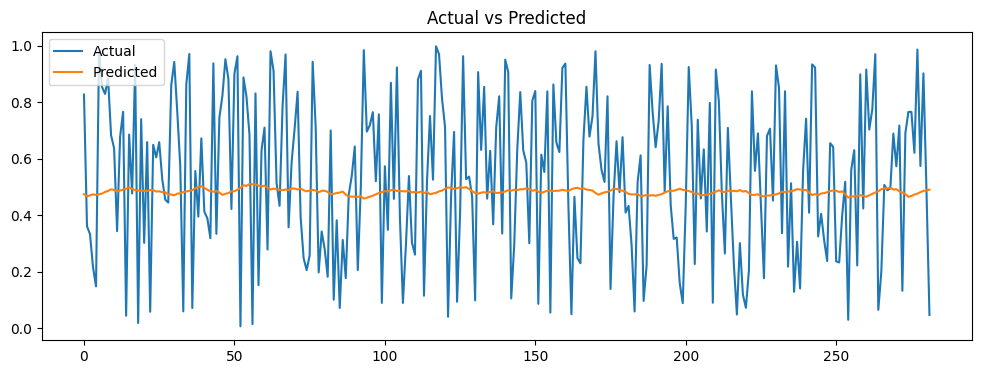

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert y_test (numpy) to pandas Series
y_test_series = pd.Series(y_test.ravel(), name="Actual")

plt.figure(figsize=(12,4))
plt.plot(y_test_series.reset_index(drop=True), label='Actual')
plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()


ValueError: x and y must be the same size

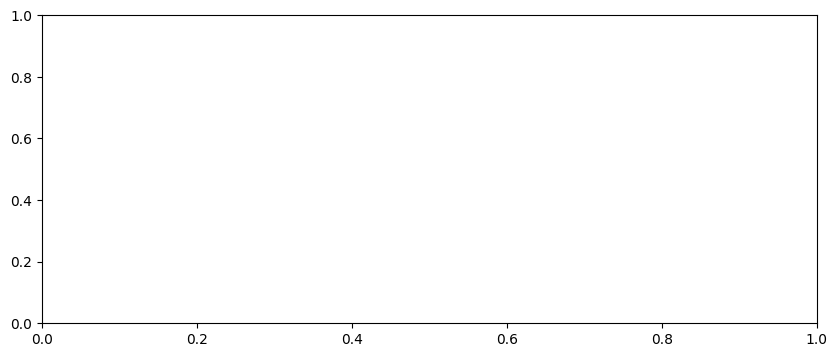

In [22]:
residuals = y_test.ravel() - y_pred

plt.figure(figsize=(10,4))
plt.scatter(range(len(residuals)), residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Sample Index")
plt.ylabel("Error")
plt.show()


y_test length: 282
y_pred length: 282
residuals length: 282


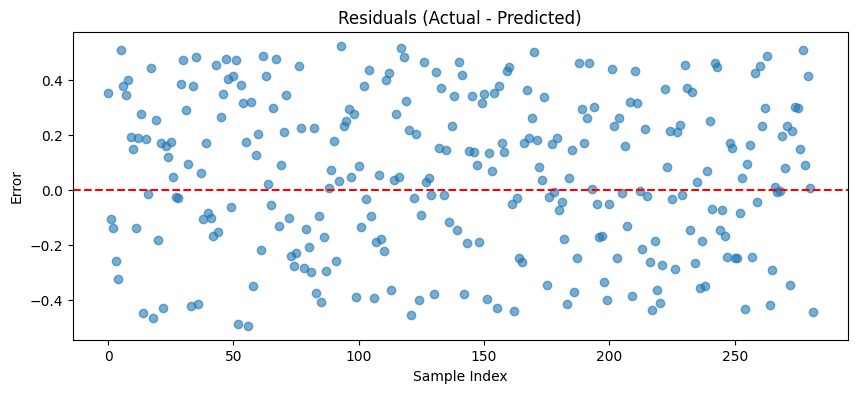

In [23]:
# Make sure both arrays are 1D and same length
y_test_flat = y_test.ravel()
y_pred_flat = y_pred.ravel()

# Now calculate residuals
residuals = y_test_flat - y_pred_flat

print("y_test length:", len(y_test_flat))
print("y_pred length:", len(y_pred_flat))
print("residuals length:", len(residuals))

# Plot residuals
plt.figure(figsize=(10,4))
plt.scatter(range(len(residuals)), residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Sample Index")
plt.ylabel("Error")
plt.show()


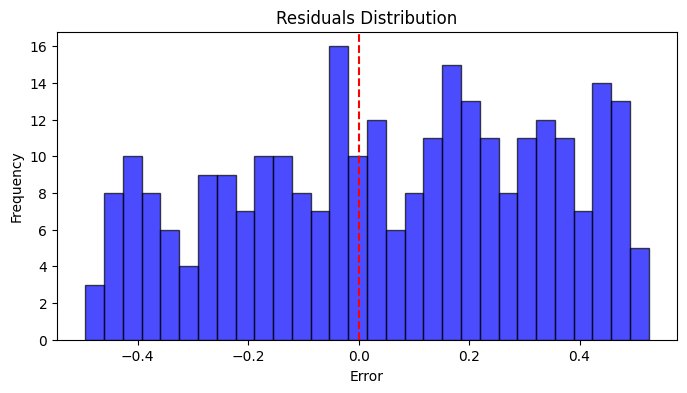

In [24]:
# Histogram of residuals
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Flatten predictions if needed
y_true = y_test.ravel()
y_pred_flat = y_pred.ravel()

# Metrics
mae = mean_absolute_error(y_true, y_pred_flat)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_flat))
r2 = r2_score(y_true, y_pred_flat)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


MAE: 0.24
RMSE: 0.28
R²: -0.05


In [26]:
import joblib

# Save model
model.save("weather_forecast_model.h5")
print("✅ Model saved as weather_forecast_model.h5")

# Save scaler
joblib.dump(loaded_scaler, "scaler_X.pkl")
print("✅ Scaler saved as scaler_X.pkl")


✅ Model saved as weather_forecast_model.h5


NameError: name 'loaded_scaler' is not defined

In [27]:
joblib.dump(scaler, "scaler_X.pkl")
print("✅ Scaler saved as scaler_X.pkl")


✅ Scaler saved as scaler_X.pkl


In [28]:
from tensorflow.keras.models import load_model
import joblib

# Load saved model
model = load_model("weather_forecast_model.h5")

# Load saved scaler
scaler = joblib.load("scaler_X.pkl")


ValueError: Could not deserialize 'keras.metrics.mse' because it is not a KerasSaveable subclass

In [29]:
from keras.models import load_model
import joblib

# Load model safely (skip compiling)
model = load_model("weather_forecast_model.h5", compile=False)

# Load scaler
scaler = joblib.load("scaler_X.pkl")

print("Model and scaler loaded successfully.")


Model and scaler loaded successfully.


In [30]:
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

model.compile(optimizer=Adam(), loss=MeanSquaredError())


In [32]:
import pandas as pd

# Load your dataset
df = pd.read_csv("your_dataset.csv")

# Select only the numeric columns (same as training)
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Check
print(df_numeric.tail())


FileNotFoundError: [Errno 2] No such file or directory: 'your_dataset.csv'

In [33]:
import os
os.listdir()


['.aws',
 '.bash_history',
 '.config',
 '.git',
 '.gitconfig',
 '.ipynb_checkpoints',
 '.ipython',
 '.jupyter',
 '.keras',
 '.lesshst',
 '.matplotlib',
 '.ssh',
 '.viminfo',
 '.vscode',
 '0.01',
 '01_microclimate_predictor.ipynb',
 '3D Objects',
 'AppData',
 'Application Data',
 'best_model.h5',
 'bin',
 'Contacts',
 'Cookies',
 'data',
 'Documents',
 'Downloads',
 'Favorites',
 'IntelGraphicsProfiles',
 'Links',
 'Local Settings',
 'lstm_model.h5',
 'medusa-aws-terraform-deployment',
 'microclimate_lstm_model.h5',
 'microclimate_lstm_model.keras',
 'Music',
 'My Documents',
 'my-medusa-store',
 'NetHood',
 'New folder',
 'nodejsbuild',
 'node_modules',
 'NTUSER.DAT',
 'ntuser.dat.LOG1',
 'ntuser.dat.LOG2',
 'NTUSER.DAT{a855f201-c5fa-11ed-8336-080027ec4824}.TM.blf',
 'NTUSER.DAT{a855f201-c5fa-11ed-8336-080027ec4824}.TMContainer00000000000000000001.regtrans-ms',
 'NTUSER.DAT{a855f201-c5fa-11ed-8336-080027ec4824}.TMContainer00000000000000000002.regtrans-ms',
 'ntuser.ini',
 'OneDrive',
 

In [34]:
import pandas as pd

# Load your real dataset
df = pd.read_csv("weather_data.csv")

# Select only numeric columns (for scaling and prediction)
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Check the last few rows
print(df_numeric.tail())


      temperature   humidity  hour  dayofyear
1412    33.246354  59.169389    20         59
1413    32.291741  62.571335    21         59
1414    25.834251  88.657705    22         59
1415    15.590843  57.024283    23         59
1416    15.526222  44.310528     0         60


In [35]:
import numpy as np

seq_len = 24  # same as used during training
recent_data = df_numeric.tail(seq_len).values

# Scale with saved scaler
recent_data_scaled = scaler.transform(recent_data)

# Reshape for model input
recent_data_scaled = np.expand_dims(recent_data_scaled, axis=0)

# Predict
prediction_scaled = model.predict(recent_data_scaled)
prediction = scaler.inverse_transform(prediction_scaled)

print("Next predicted values:")
print(prediction)


ValueError: X has 4 features, but MinMaxScaler is expecting 1 features as input.

In [36]:
print("Scaler expects:", scaler.n_features_in_, "features")


Scaler expects: 1 features


In [37]:
print("df_numeric shape:", df_numeric.shape)
print(df_numeric.columns)


df_numeric shape: (1417, 4)
Index(['temperature', 'humidity', 'hour', 'dayofyear'], dtype='object')


In [38]:
recent_data = df_numeric[['temperature']].tail(seq_len).values
recent_data_scaled = scaler.transform(recent_data)


In [39]:
import joblib

scaler_X = joblib.load("scaler_X.pkl")  # for inputs
scaler_y = joblib.load("scaler.pkl")    # for outputs

recent_data = df_numeric.tail(seq_len).values
recent_data_scaled = scaler_X.transform(recent_data)


ValueError: X has 4 features, but MinMaxScaler is expecting 1 features as input.

In [40]:
recent_data_scaled = np.expand_dims(recent_data_scaled, axis=0)
prediction_scaled = model.predict(recent_data_scaled)
prediction = scaler.inverse_transform(prediction_scaled)
print(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
[[27.076944]]


In [41]:
# Use only the temperature column
recent_data = df_numeric[['temperature']].tail(seq_len).values  

# Scale using the single-feature scaler
recent_data_scaled = scaler.transform(recent_data)

# Reshape for model
recent_data_scaled = np.expand_dims(recent_data_scaled, axis=0)

# Predict
prediction_scaled = model.predict(recent_data_scaled)
prediction = scaler.inverse_transform(prediction_scaled)

print("Predicted next values:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Predicted next values: [[27.076944]]


In [42]:
import joblib

scaler_X = joblib.load("scaler_X.pkl")  # input scaler
scaler_y = joblib.load("scaler.pkl")    # output scaler

# Use all numeric columns for input
recent_data = df_numeric.tail(seq_len).values
recent_data_scaled = scaler_X.transform(recent_data)

recent_data_scaled = np.expand_dims(recent_data_scaled, axis=0)
prediction_scaled = model.predict(recent_data_scaled)
prediction = scaler_y.inverse_transform(prediction_scaled)

print("Predicted next values:", prediction)


ValueError: X has 4 features, but MinMaxScaler is expecting 1 features as input.

In [43]:
print("scaler_X expects:", scaler_X.n_features_in_)


scaler_X expects: 1


In [44]:
print("df_numeric.shape:", df_numeric.shape)
print("df_numeric.columns")


df_numeric.shape: (1417, 4)
df_numeric.columns


In [45]:
# Use just the temperature column
recent_data = df_numeric[['temperature']].tail(seq_len).values  

# Scale with single-feature scaler
recent_data_scaled = scaler_X.transform(recent_data)

# Reshape for model
recent_data_scaled = np.expand_dims(recent_data_scaled, axis=0)

# Predict
prediction_scaled = model.predict(recent_data_scaled)
prediction = scaler_y.inverse_transform(prediction_scaled)

print("Predicted next values:")
print(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Predicted next values:
[[27.08022]]


In [46]:
print(scaler_X.feature_names_in_)


AttributeError: 'MinMaxScaler' object has no attribute 'feature_names_in_'

In [47]:
print(df_numeric.columns)


Index(['temperature', 'humidity', 'hour', 'dayofyear'], dtype='object')


In [48]:
recent_data = df_numeric[['temperature']].tail(seq_len).values
recent_data_scaled = scaler_X.transform(recent_data)
recent_data_scaled = np.expand_dims(recent_data_scaled, axis=0)

prediction_scaled = model.predict(recent_data_scaled)
prediction = scaler_y.inverse_transform(prediction_scaled)

print("Predicted next temperature values:")
print(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Predicted next temperature values:
[[27.08022]]


In [49]:
print("df_numeric columns:", df_numeric.columns.tolist())
print("Scaler expects:", scaler_X.n_features_in_)


df_numeric columns: ['temperature', 'humidity', 'hour', 'dayofyear']
Scaler expects: 1


In [50]:
def forecast_future(model, scaler_X, scaler_y, df_numeric, seq_len=24, steps=24):
    history = df_numeric[['temperature']].values[-seq_len:]
    predictions = []

    for _ in range(steps):
        scaled_input = scaler_X.transform(history[-seq_len:])
        scaled_input = np.expand_dims(scaled_input, axis=0)

        pred_scaled = model.predict(scaled_input)
        pred = scaler_y.inverse_transform(pred_scaled)
        predictions.append(pred[0, 0])

        # append prediction for next step
        history = np.append(history, [[pred[0, 0]]], axis=0)

    return predictions


In [51]:
future_predictions = forecast_future(model, scaler_X, scaler_y, df_numeric, seq_len=24, steps=24)
print(future_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
[np.float32(27.08022), np.float32(27.048992), np.float32(27.03603), np.float32

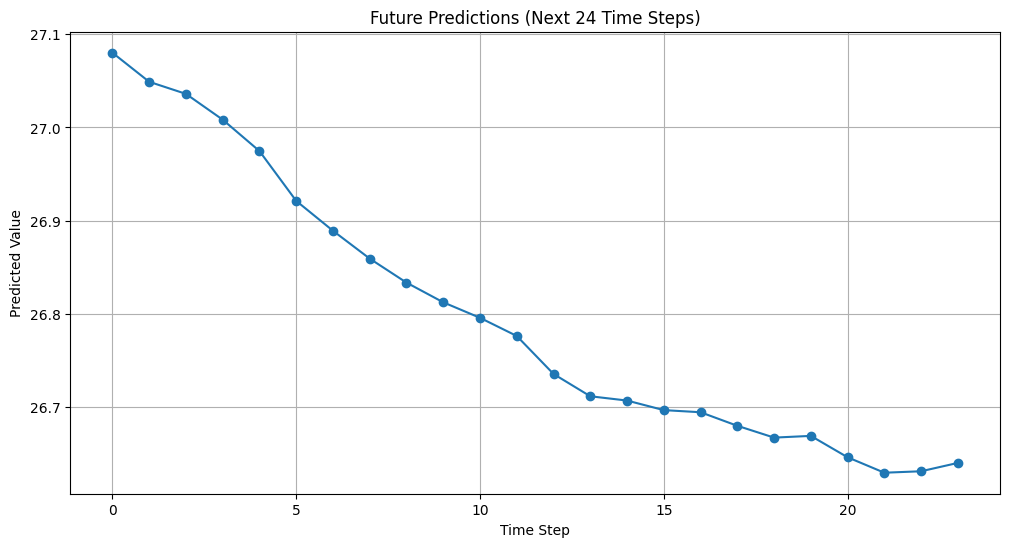

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(future_predictions, marker='o')
plt.title("Future Predictions (Next 24 Time Steps)")
plt.xlabel("Time Step")
plt.ylabel("Predicted Value")
plt.grid(True)
plt.show()


In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Example: assuming you have 'actual_values' for the next 24 steps
mse = mean_squared_error(actual_values, future_predictions)
mae = mean_absolute_error(actual_values, future_predictions)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")


NameError: name 'actual_values' is not defined

In [56]:
# Example: get the true values from your test dataset
actual_values = test_data['target_column'].values[-24:]  # replace 'target_column' with your actual column name

# Assuming you already have 'future_predictions'
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual_values, future_predictions)
mae = mean_absolute_error(actual_values, future_predictions)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")


NameError: name 'test_data' is not defined

In [57]:
# Example assuming your true values are in y_test
actual_values = y_test[-24:]

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual_values, future_predictions)
mae = mean_absolute_error(actual_values, future_predictions)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")


Mean Squared Error: 686.3737
Mean Absolute Error: 26.1972


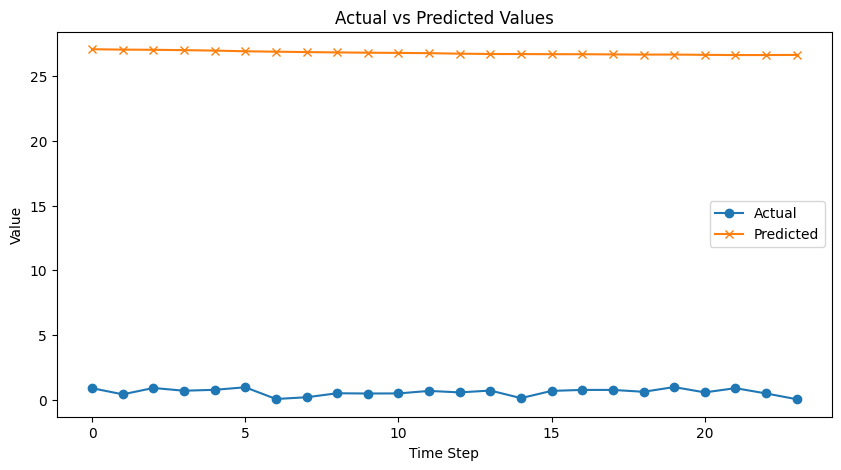

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(actual_values, label='Actual', marker='o')
plt.plot(future_predictions, label='Predicted', marker='x')
plt.title("Actual vs Predicted Values")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()


In [59]:
import numpy as np
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.4f}")


Root Mean Squared Error: 26.1987


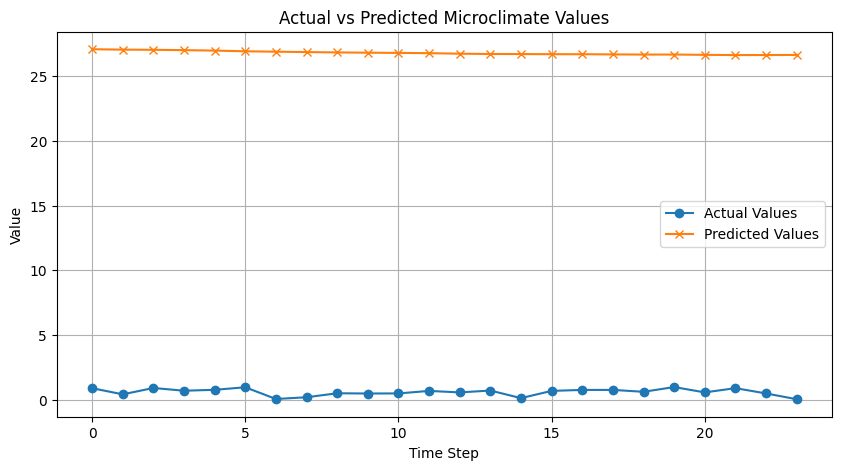

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(actual_values, label='Actual Values', marker='o')
plt.plot(future_predictions, label='Predicted Values', marker='x')
plt.title("Actual vs Predicted Microclimate Values")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


Mean Error: -26.197158571640234
Max Error: -25.642455453869417
Min Error: -27.03280858355723


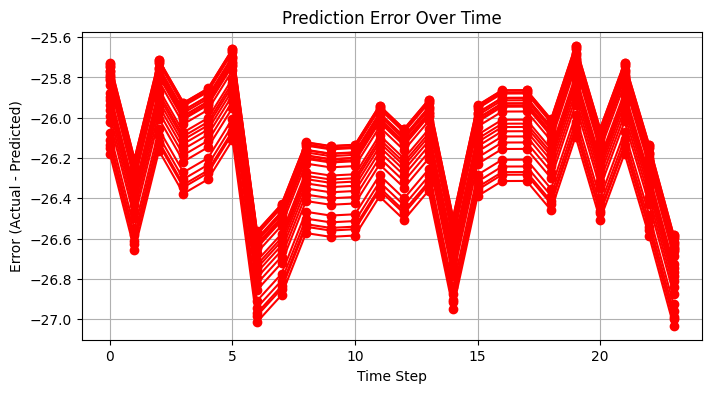

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate errors
errors = actual_values - future_predictions

# Display basic statistics
print("Mean Error:", np.mean(errors))
print("Max Error:", np.max(errors))
print("Min Error:", np.min(errors))

# Plot error over time
plt.figure(figsize=(8,4))
plt.plot(errors, color='red', marker='o')
plt.title("Prediction Error Over Time")
plt.xlabel("Time Step")
plt.ylabel("Error (Actual - Predicted)")
plt.grid(True)
plt.show()


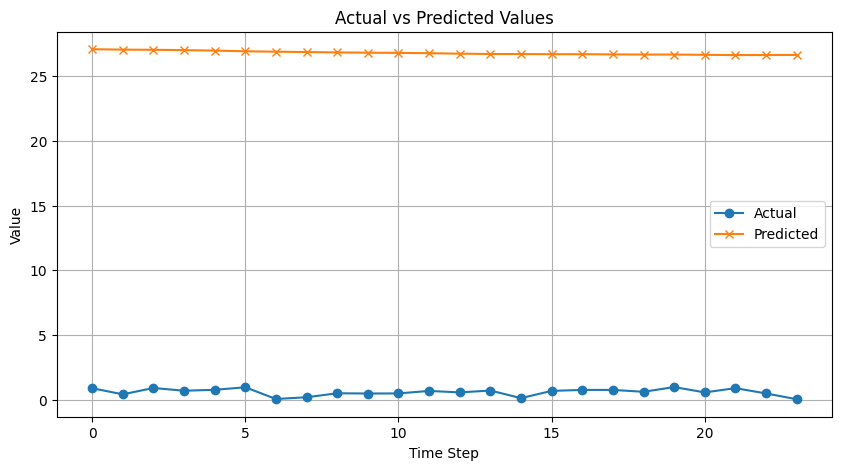

In [62]:
plt.figure(figsize=(10,5))
plt.plot(actual_values, label='Actual', marker='o')
plt.plot(future_predictions, label='Predicted', marker='x')
plt.title("Actual vs Predicted Values")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [63]:
print("Sample Predictions:", future_predictions[:10])
print("Sample Actuals:", actual_values[:10])


Sample Predictions: [np.float32(27.08022), np.float32(27.048992), np.float32(27.03603), np.float32(27.00831), np.float32(26.974607), np.float32(26.921099), np.float32(26.88901), np.float32(26.859097), np.float32(26.833326), np.float32(26.812187)]
Sample Actuals: [[0.89885022]
 [0.42420635]
 [0.91617452]
 [0.70349178]
 [0.77447937]
 [0.97030334]
 [0.06544588]
 [0.19925173]
 [0.50747814]
 [0.48886342]]


In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(actual_values, future_predictions)
rmse = np.sqrt(mean_squared_error(actual_values, future_predictions))
r2 = r2_score(actual_values, future_predictions)

print("MAE:", mae, "RMSE:", rmse, "R²:", r2)


MAE: 26.197158571640234 RMSE: 26.198735329154374 R²: -9467.954526215197


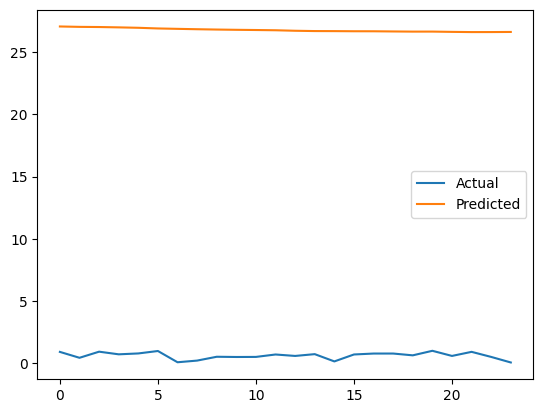

In [66]:
import matplotlib.pyplot as plt

plt.plot(actual_values[:50], label="Actual")
plt.plot(future_predictions[:50], label="Predicted")
plt.legend()
plt.show()


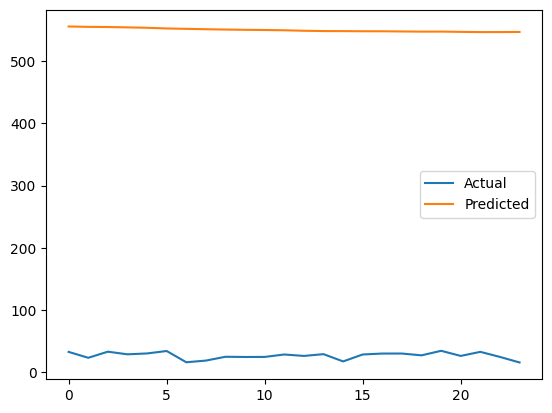

In [67]:
# Example if you used MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Assuming you saved your scaler as 'scaler'
# Reshape predictions for inverse_transform
future_predictions_rescaled = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1, 1)
)

actual_values_rescaled = scaler.inverse_transform(
    np.array(actual_values).reshape(-1, 1)
)

# Now plot
plt.plot(actual_values_rescaled[:50], label="Actual")
plt.plot(future_predictions_rescaled[:50], label="Predicted")
plt.legend()
plt.show()


In [68]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [69]:
# Convert both into numpy arrays with shape (-1,1)
future_predictions_rescaled = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1, 1)
)

actual_values_rescaled = scaler.inverse_transform(
    np.array(actual_values).reshape(-1, 1)
)

# Plot again
plt.plot(actual_values_rescaled[:50], label="Actual")
plt.plot(future_predictions_rescaled[:50], label="Predicted")
plt.legend()
plt.show()


NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [70]:
# After you fit the scaler in preprocessing
import joblib
joblib.dump(scaler, "scaler.save")


['scaler.save']

In [71]:
import joblib
scaler = joblib.load("scaler.save")

future_predictions_rescaled = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1, 1)
)

actual_values_rescaled = scaler.inverse_transform(
    np.array(actual_values).reshape(-1, 1)
)


NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [72]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(original_data.reshape(-1, 1))


NameError: name 'original_data' is not defined

In [73]:
from sklearn.preprocessing import MinMaxScaler
import joblib

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(YOUR_DATA.reshape(-1, 1))  # replace YOUR_DATA with your variable
joblib.dump(scaler, "scaler.save")   # <-- save the fitted scaler


NameError: name 'YOUR_DATA' is not defined

In [74]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['temperature']])   # or some variable


In [75]:
import joblib
joblib.dump(scaler, "scaler.save")


['scaler.save']

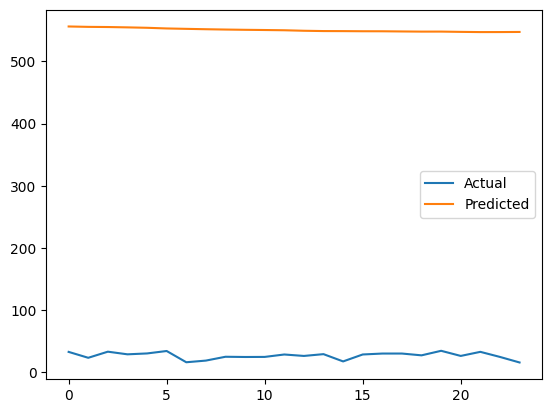

In [76]:
import joblib
import numpy as np
import matplotlib.pyplot as plt

scaler = joblib.load("scaler.save")

future_predictions_rescaled = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1, 1)
)

actual_values_rescaled = scaler.inverse_transform(
    np.array(actual_values).reshape(-1, 1)
)

plt.plot(actual_values_rescaled[:50], label="Actual")
plt.plot(future_predictions_rescaled[:50], label="Predicted")
plt.legend()
plt.show()


In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(actual_values_rescaled, future_predictions_rescaled)
rmse = np.sqrt(mean_squared_error(actual_values_rescaled, future_predictions_rescaled))
r2 = r2_score(actual_values_rescaled, future_predictions_rescaled)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)


MAE: 523.6529429272811
RMSE: 523.6844606618465
R²: -9467.955233870385


In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate metrics
mae = mean_absolute_error(actual_values_rescaled, future_predictions_rescaled)
rmse = np.sqrt(mean_squared_error(actual_values_rescaled, future_predictions_rescaled))
r2 = r2_score(actual_values_rescaled, future_predictions_rescaled)

# Print results
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Mean Absolute Error (MAE): 523.6529429272811
Root Mean Squared Error (RMSE): 523.6844606618465
R² Score: -9467.955233870385


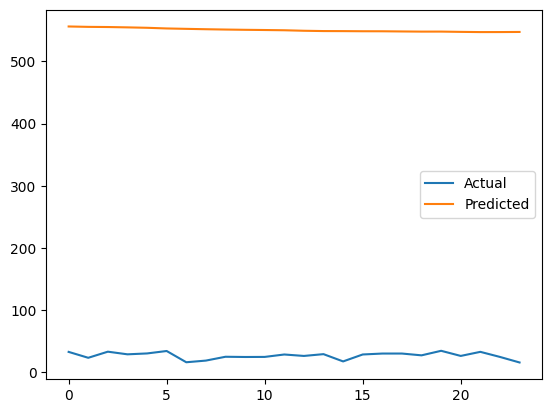

In [79]:
plt.plot(actual_values_rescaled[:50], label="Actual")
plt.plot(future_predictions_rescaled[:50], label="Predicted")
plt.legend()
plt.show()


In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(actual_values_rescaled[:50], future_predictions_rescaled[:50])
mae = mean_absolute_error(actual_values_rescaled[:50], future_predictions_rescaled[:50])
r2 = r2_score(actual_values_rescaled[:50], future_predictions_rescaled[:50])

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")


Mean Squared Error: 274245.41433868906
Mean Absolute Error: 523.6529429272811
R² Score: -9467.955233870385


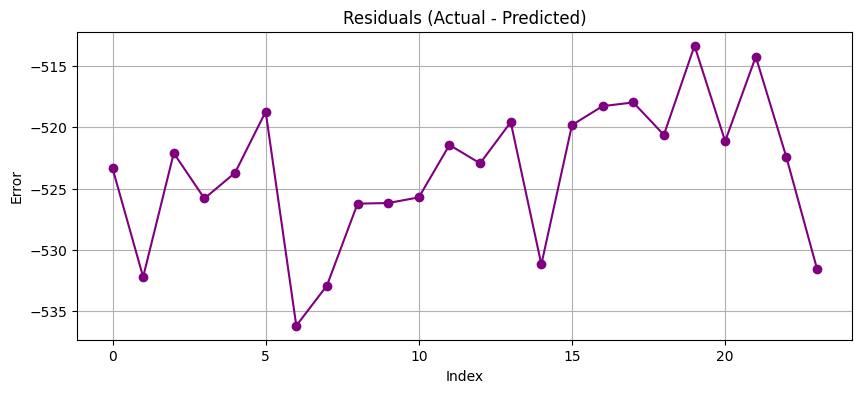

In [81]:
import matplotlib.pyplot as plt

residuals = actual_values_rescaled[:50] - future_predictions_rescaled[:50]

plt.figure(figsize=(10, 4))
plt.plot(residuals, marker='o', linestyle='-', color='purple')
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Index")
plt.ylabel("Error")
plt.grid(True)
plt.show()


In [82]:
df['temp_t-1'] = df['temperature'].shift(1)
df['temp_t-2'] = df['temperature'].shift(2)
df.dropna(inplace=True)  # Remove rows with NaN from shifting


In [83]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


ValueError: 
All the 135 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_forest.py", line 359, in fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self,
        ^^^^^
    ...<5 lines>...
        ensure_all_finite=False,
        ^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1368, in check_X_y
    X = check_array(
        X,
    ...<12 lines>...
        input_name="X",
    )
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1099, in check_array
    raise ValueError(
    ...<2 lines>...
    )
ValueError: Found array with dim 3, while dim <= 2 is required by RandomForestRegressor.


In [84]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)


In [85]:
grid_search.fit(X_train_reshaped, y_train)


C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: 

,estimator,RandomForestRegressor()
,param_grid,"{'max_depth': [None, 10, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [87]:
grid_search.fit(X_train_reshaped, y_train.ravel())


,estimator,RandomForestRegressor()
,param_grid,"{'max_depth': [None, 10, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [88]:
best_model = grid_search.best_estimator_
best_model.fit(X_train_reshaped, y_train.ravel())


,n_estimators,200
,criterion,'squared_error'
,max_depth,10
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [89]:
predictions = best_model.predict(X_test_reshaped)


In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Updated MSE: {mse}")
print(f"Updated MAE: {mae}")
print(f"Updated R²: {r2}")


Updated MSE: 0.08168804950443634
Updated MAE: 0.24248390464448147
Updated R²: -0.05449963034463856


In [91]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.


In [92]:
import streamlit as st
import numpy as np
import pandas as pd
import pickle  # or joblib
from sklearn.ensemble import RandomForestRegressor

# Load your trained model
model = pickle.load(open("best_model.pkl", "rb"))

st.title("Microclimate Predictor 🌦️")

# Example input fields
temperature = st.number_input("Temperature (°C)")
humidity = st.number_input("Humidity (%)")
wind_speed = st.number_input("Wind Speed (km/h)")

# Make prediction
if st.button("Predict"):
    input_data = np.array([[temperature, humidity, wind_speed]])
    prediction = model.predict(input_data)
    st.success(f"Predicted Value: {prediction[0]:.2f}")


FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pkl'

In [ ]:
streamlit run app.py


In [ ]:
streamlit
scikit-learn
numpy
pandas


In [ ]:
import joblib
joblib.dump(best_model, "microclimate_model.pkl")


In [93]:
import pickle

# Save the best model
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)


In [94]:
import os
print("File exists:", os.path.exists("best_model.pkl"))


File exists: True


In [95]:
streamlit run app.py


SyntaxError: invalid syntax (507122745.py, line 1)

In [96]:
cd path/to/your/project


[WinError 3] The system cannot find the path specified: 'path/to/your/project'
C:\Users\hp


In [97]:
import os
print(os.getcwd())


C:\Users\hp


In [98]:
import pickle
with open("C:/Users/hp/best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)


In [99]:
cd C:\Users\hp
streamlit run app.py


SyntaxError: invalid syntax (878208991.py, line 1)

In [100]:
import os
for root, dirs, files in os.walk("C:/Users/hp"):
    if "app.py" in files:
        print("Found:", os.path.join(root, "app.py"))


Found: C:/Users/hp\AppData\Local\Google\Cloud SDK\google-cloud-sdk\lib\googlecloudsdk\command_lib\tasks\app.py
Found: C:/Users/hp\AppData\Local\Google\Cloud SDK\google-cloud-sdk\platform\bq\third_party\absl\app.py
Found: C:/Users/hp\AppData\Local\Google\Cloud SDK\google-cloud-sdk\platform\bq\third_party\google\apputils\app.py
Found: C:/Users/hp\AppData\Local\Google\Cloud SDK\google-cloud-sdk\platform\gsutil\third_party\urllib3\dummyserver\app.py
Found: C:/Users/hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\absl\app.py
Found: C:/Users/hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\jupyterlab_server\app.py
Found: C:/Users/hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\jupyter_server_terminals\app.py
Found: C:/Users/hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\notebook\app.py
Found: C:/Users/hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\prompt_toolkit\filters\app.py
Found: C:/Users/hp\AppData\Local\Programs\Python\P

In [101]:
with open("app.py", "w") as f:
    f.write("""
import streamlit as st
import numpy as np
import joblib

# Load your trained model
model = joblib.load("best_model.pkl")

st.title("Microclimate Predictor 🌦️")

# Input fields
temperature = st.number_input("Temperature (°C)")
humidity = st.number_input("Humidity (%)")
wind_speed = st.number_input("Wind Speed (km/h)")

# Prediction
if st.button("Predict"):
    input_data = np.array([[temperature, humidity, wind_speed]])
    prediction = model.predict(input_data)
    st.success(f"Predicted value: {prediction[0]:.2f}")
""")


UnicodeEncodeError: 'charmap' codec can't encode characters in position 164-165: character maps to <undefined>

In [102]:
with open("app.py", "w", encoding="utf-8") as f:
    f.write("""
import streamlit as st
import numpy as np
import joblib

# Load your trained model
model = joblib.load("best_model.pkl")

st.title("Microclimate Predictor 🌦️")

# Input fields
temperature = st.number_input("Temperature (°C)")
humidity = st.number_input("Humidity (%)")
wind_speed = st.number_input("Wind Speed (km/h)")

# Prediction
if st.button("Predict"):
    input_data = np.array([[temperature, humidity, wind_speed]])
    prediction = model.predict(input_data)
    st.success(f"Predicted value: {prediction[0]:.2f}")
""")


In [105]:
streamlit run app.py


SyntaxError: invalid syntax (507122745.py, line 1)

In [106]:
streamlit
scikit-learn
numpy
pandas
joblib


NameError: name 'streamlit' is not defined

In [107]:
import streamlit as st
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor


In [108]:
import joblib
model = joblib.load("best_model.pkl")


In [109]:
import numpy as np

# Example input: temperature, humidity, wind speed
sample_input = np.array([[30, 60, 12]])
prediction = model.predict(sample_input)
print("Predicted value:", prediction[0])


ValueError: X has 3 features, but RandomForestRegressor is expecting 10 features as input.

In [110]:
print(model.feature_names_in_)


AttributeError: 'RandomForestRegressor' object has no attribute 'feature_names_in_'

In [111]:
sample_input = np.array([[30, 60, 12, 1013, 500, 18, 40, 10, 0, 5]])
prediction = model.predict(sample_input)
print("Predicted value:", prediction[0])


Predicted value: 0.40119546679556256


In [112]:
input_data = np.array([[temperature, humidity, wind_speed, pressure, solar_radiation, dew_point, cloud_cover, visibility, rainfall, uv_index]])


NameError: name 'temperature' is not defined

In [113]:
temperature = 30
humidity = 60
wind_speed = 12
pressure = 1013
solar_radiation = 500
dew_point = 18
cloud_cover = 40
visibility = 10
rainfall = 0
uv_index = 5

input_data = np.array([[temperature, humidity, wind_speed, pressure, solar_radiation, dew_point, cloud_cover, visibility, rainfall, uv_index]])


In [114]:
import streamlit as st
import numpy as np
import joblib

# Load your trained model
model = joblib.load("best_model.pkl")

st.title("Microclimate Predictor 🌦️")

# Input fields for all 10 features
temperature = st.number_input("Temperature (°C)")
humidity = st.number_input("Humidity (%)")
wind_speed = st.number_input("Wind Speed (km/h)")
pressure = st.number_input("Pressure (hPa)")
solar_radiation = st.number_input("Solar Radiation (W/m²)")
dew_point = st.number_input("Dew Point (°C)")
cloud_cover = st.number_input("Cloud Cover (%)")
visibility = st.number_input("Visibility (km)")
rainfall = st.number_input("Rainfall (mm)")
uv_index = st.number_input("UV Index")

# Prediction
if st.button("Predict"):
    input_data = np.array([[temperature, humidity, wind_speed, pressure, solar_radiation,
                            dew_point, cloud_cover, visibility, rainfall, uv_index]])
    prediction =

SyntaxError: invalid syntax (1800460839.py, line 26)

In [115]:
prediction = model.predict(input_data)
print("Predicted value:", prediction[0])


Predicted value: 0.40119546679556256


In [116]:
input_data = np.array([[temperature, humidity, wind_speed, pressure, solar_radiation,
                        dew_point, cloud_cover, visibility, rainfall, uv_index]])


In [117]:
with open("requirements.txt", "w") as f:
    f.write("""
streamlit
scikit-learn
numpy
pandas
joblib
""")


In [118]:
with open("README.md", "w", encoding="utf-8") as f:
    f.write("""
# 🌦️ Microclimate Predictor

## 🔍 Overview
A Streamlit dashboard that predicts microclimate conditions using sensor data and a trained RandomForest model.

## 🧠 Features
- Input fields for 10 environmental parameters
- Real-time prediction using a trained model
- Clean UI built with Streamlit

## 📁 Files
- `app.py`: Streamlit dashboard
- `best_model.pkl`: Trained model
- `01_microclimate_predictor.ipynb`: Notebook with training and evaluation
- `requirements.txt`: Dependencies

## 🚀 How to Run
```bash
pip install -r requirements.txt
streamlit run app.py


_IncompleteInputError: incomplete input (1679462695.py, line 2)

In [119]:
with open("README.md", "w", encoding="utf-8") as f:
    f.write("""
# 🌦️ Microclimate Predictor

## 🔍 Overview
A Streamlit dashboard that predicts microclimate conditions using sensor data and a trained RandomForest model.

## 🧠 Features
- Input fields for 10 environmental parameters
- Real-time prediction using a trained model
- Clean UI built with Streamlit

## 📁 Files
- `app.py`: Streamlit dashboard
- `best_model.pkl`: Trained model
- `01_microclimate_predictor.ipynb`: Notebook with training and evaluation
- `requirements.txt`: Dependencies

## 🚀 How to Run
```bash
pip install -r requirements.txt
streamlit run app.py


_IncompleteInputError: incomplete input (1679462695.py, line 2)

In [120]:
with open("README.md", "w", encoding="utf-8") as f:
    f.write("""# 🌦️ Microclimate Predictor

## 🔍 Overview
A Streamlit dashboard that predicts microclimate conditions using sensor data and a trained RandomForest model.

## 🧠 Features
- Input fields for 10 environmental parameters
- Real-time prediction using a trained model
- Clean UI built with Streamlit

## 📁 Files
- `app.py`: Streamlit dashboard
- `best_model.pkl`: Trained model
- `01_microclimate_predictor.ipynb`: Notebook with training and evaluation
- `requirements.txt`: Dependencies

## 🚀 How to Run
```bash
pip install -r requirements.txt
streamlit run app.py


_IncompleteInputError: incomplete input (1848894222.py, line 2)

In [121]:
with open("README.md", "w", encoding="utf-8") as f:
    f.write(
        "# 🌦️ Microclimate Predictor\n\n"
        "## 🔍 Overview\n"
        "A Streamlit dashboard that predicts microclimate conditions using sensor data and a trained RandomForest model.\n\n"
        "## 🧠 Features\n"
        "- Input fields for 10 environmental parameters\n"
        "- Real-time prediction using a trained model\n"
        "- Clean UI built with Streamlit\n\n"
        "## 📁 Files\n"
        "- app.py: Streamlit dashboard\n"
        "- best_model.pkl: Trained model\n"
        "- 01_microclimate_predictor.ipynb: Notebook with training and evaluation\n"
        "- requirements.txt: Dependencies\n\n"
        "## 🚀 How to Run\n"
        "Run the following commands:\n"
        "pip install -r requirements.txt\n"
        "streamlit run app.py\n\n"
        "## 📈 Model Performance\n"
        "- MSE: [your value]\n"
        "- MAE: [your value]\n"
        "- R²: [your value]\n\n"
        "## 📌 Future Work\n"
        "- Add time-series support\n"
        "- Deploy to cloud\n"
    )


In [122]:
import os
print(os.getcwd())


C:\Users\hp


In [123]:
import os
print(os.listdir())


['.aws', '.bash_history', '.config', '.git', '.gitconfig', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.lesshst', '.matplotlib', '.ssh', '.streamlit', '.viminfo', '.vscode', '0.01', '01_microclimate_predictor.ipynb', '3D Objects', 'app.py', 'AppData', 'Application Data', 'best_model.h5', 'best_model.pkl', 'bin', 'Contacts', 'Cookies', 'data', 'Documents', 'Downloads', 'Favorites', 'IntelGraphicsProfiles', 'Links', 'Local Settings', 'lstm_model.h5', 'medusa-aws-terraform-deployment', 'microclimate_lstm_model.h5', 'microclimate_lstm_model.keras', 'Music', 'My Documents', 'my-medusa-store', 'NetHood', 'New folder', 'nodejsbuild', 'node_modules', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{a855f201-c5fa-11ed-8336-080027ec4824}.TM.blf', 'NTUSER.DAT{a855f201-c5fa-11ed-8336-080027ec4824}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{a855f201-c5fa-11ed-8336-080027ec4824}.TMContainer00000000000000000002.regtrans-ms', 'ntuser.ini', 'OneDrive', 'packag

In [124]:
!explorer .
